#### Code to plot sat GOES data using same plot font size and conventions than other plots in the paper.
#### the code is taken from the code elaborated by Giacomo Labbri and present in the github repository
#### date: 09/12/2021
#### Author: Giacomo Labbri, Claudia Acquistapace
#### goal: read the ncdf data contained in satellite_data folder and produce 2d histograms for cloud optical thickness and cloud cover as a function of SST.


In [1]:

import pandas as pd
import custom_color_palette as ccp #for custum colormaps
import matplotlib as mpl
import matplotlib.pyplot as plt
import custom_color_palette as ccp
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
#import cartopy.crs as ccrs
#import cartopy.feature as cf
#from cartopy.feature import NaturalEarthFeature
#from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
#import pyproj as pyproj
from pyresample import utils
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
import datetime as dt
from datetime import datetime, timezone
import cftime
import scipy.stats as stats # for Mann_whitney test
from decimal import *

# modules to download: eurec4a, GOES, cartopy 

In [2]:
# setting directories
path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/satellite_data/'
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# reading the sst MUR data from the satellite folder
SST = xr.open_dataarray(path+'2-3 Feb LT_SST_MUR_regridded.nc')
date = '2-3 Feb LT' 

#load the BCM all saved to netcdf (this is to save the time to run the previous section)
BCMall = xr.open_dataarray(path + date + '_CODall_GOES.nc')
SST_repeat = np.repeat(SST.data[:,:,np.newaxis], BCMall.shape[2], axis=2)


/var/folders/vq/pfv4n2796kvc782gmx0q4bhc0000gn/T/ipykernel_14154/2568018237.py:21: RuntimeWarning: divide by zero encountered in log10
  counts = np.log10(hist2d_COD)


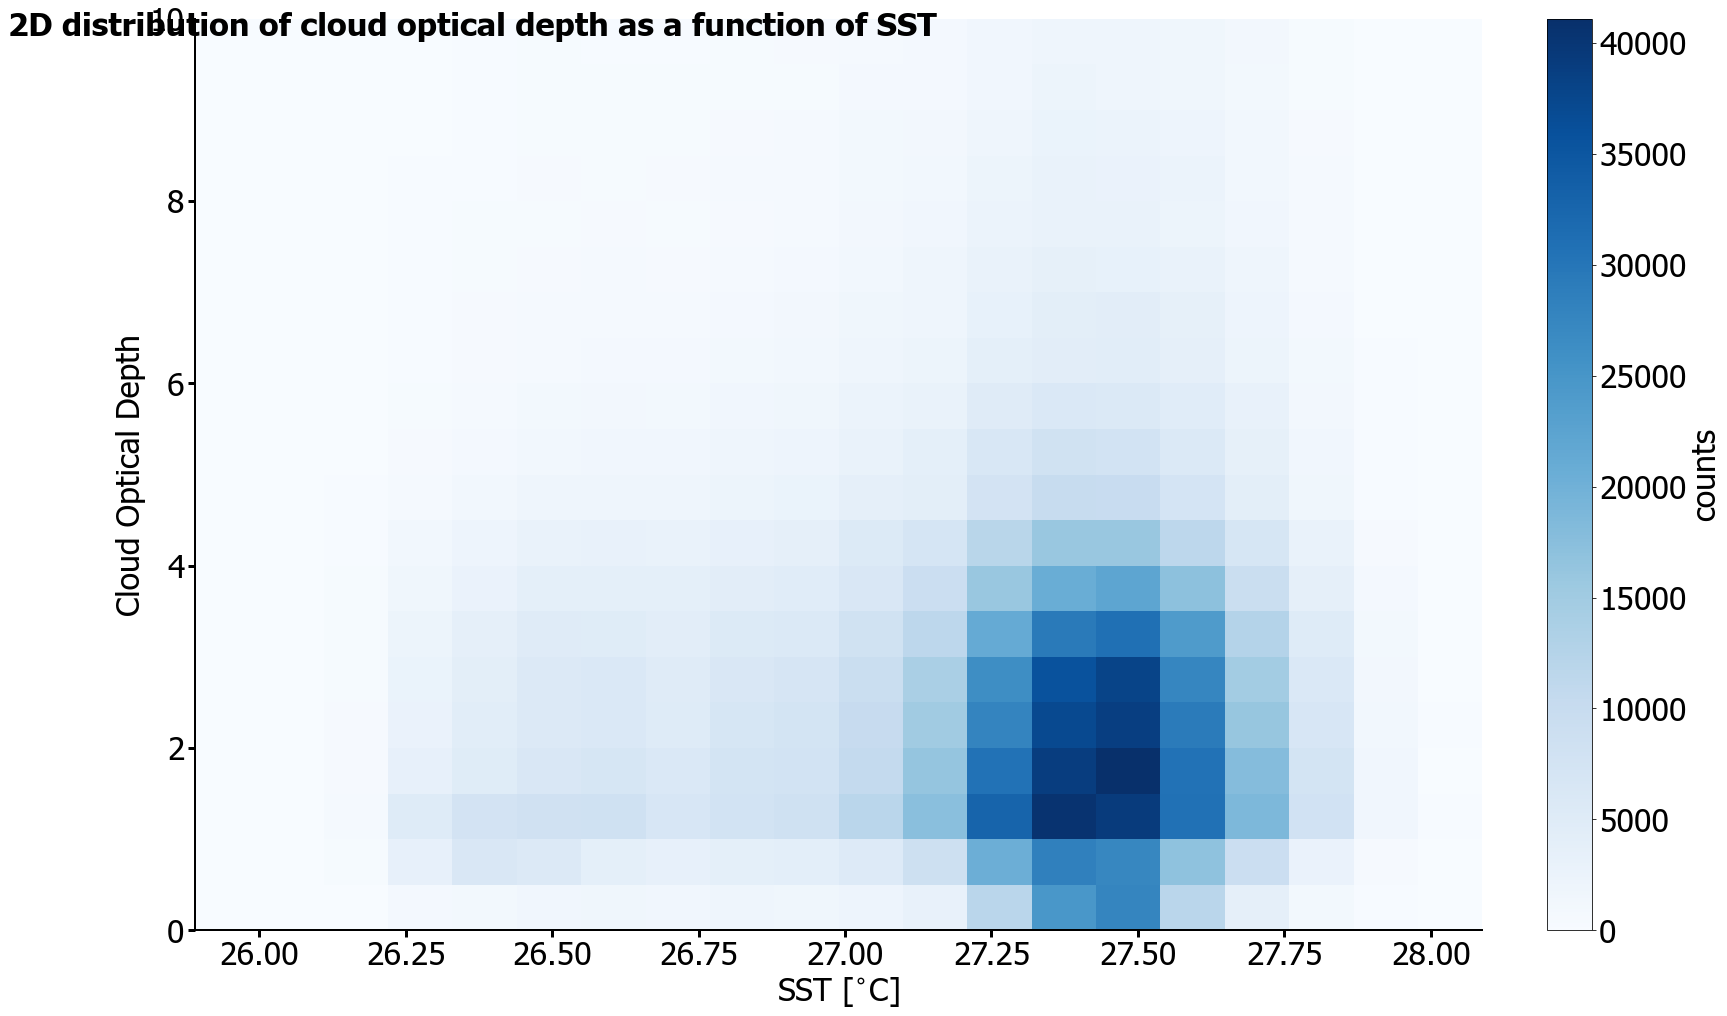

In [18]:
from matplotlib import rcParams

dict_plot_settings = {
    'labelsize'    :32,
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :32,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


hist2d_COD, xbins, ybins = np.histogram2d(SST_repeat.flatten(order='C'), \
                  BCMall.data.flatten(order='C'), \
                  bins=20, range=[[SST.min().data,SST.max().data],[BCMall.min().data, 10]], \
                  density=False)
counts = np.log10(hist2d_COD)

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']

rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
matplotlib.rc('xtick', labelsize=dict_plot_settings['labelsize'])  # sets dimension of ticks in the plots
matplotlib.rc('ytick', labelsize=dict_plot_settings['labelsize'])  # sets dimension of ticks in the plots
fig, axs = plt.subplots(figsize=(24,14), constrained_layout=True)

axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.get_xaxis().tick_bottom()
axs.get_yaxis().tick_left()
axs.spines["bottom"].set_linewidth(2)
axs.spines["left"].set_linewidth(2)
axs.tick_params(which='minor', length=7, width=3)
axs.tick_params(which='major', length=7, width=3)
axs.text(-0.05, 1.1, '2D distribution of cloud optical depth as a function of SST',  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)

plt.hist2d(SST_repeat.flatten(order='C'), BCMall.data.flatten(order='C'),
           range=[[SST.min().data,SST.max().data],[BCMall.min().data, 10]],
           bins = 20, cmap='Blues')
#mesh = axs.pcolormesh(xbins, ybins, hist2d_COD, \
#                      range=[[SST.min().data,SST.max().data],\
#                      [BCMall.min().data, 10]],\
#                      bins = 20, cmap='Blues')
#cbar = fig.colorbar(mesh, ax=axs)
#cbar.set_label(label='Occurrences []',  size=fontSizeX)
#cs = axs.contour(xbins, ybins, counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
#axs.clabel(cs, inline=1, fontsize=25)
plt.colorbar(label='counts')
plt.ylabel('Cloud Optical Depth')
plt.xlabel('SST [$^{\circ}$C]')
#save the figure
plt.savefig(path_out_plots + 'figure_GOES_COD.png',bbox_inches='tight',dpi=300)


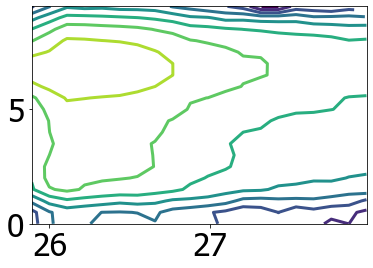

In [21]:
plt.contour(xbins[0:-1], ybins[0:-1], counts, extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)

In [25]:
axs.contour(ybins[0:-1], xbins[0:-1], hist2d_COD.T, extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],linewidths=3)


In [33]:
# reading now the cloud cover data 
#%% figure: 2-dimensional probability density function: Cloud mask vs SST

#load the BCM all saved to netcdf (this is to save the time to run the previous section)
BCMall = xr.open_dataarray(path + date + '_ACMall_GOES.nc')

#eliminate the land part of the BCMall basd on the SST maps (the SST map is nan on land)
index_values = np.ones(BCMall.shape, dtype=bool)

index_values[:,:, 0] = ~np.isnan(SST)
BCMall_wo_land = BCMall
BCMall_wo_land = BCMall.where(index_values, other = np.nan)



CC = BCMall_wo_land.data

# calcolo cloud cover totale 
cc = np.nansum(CC,axis=2)/CC[1,1,:].size



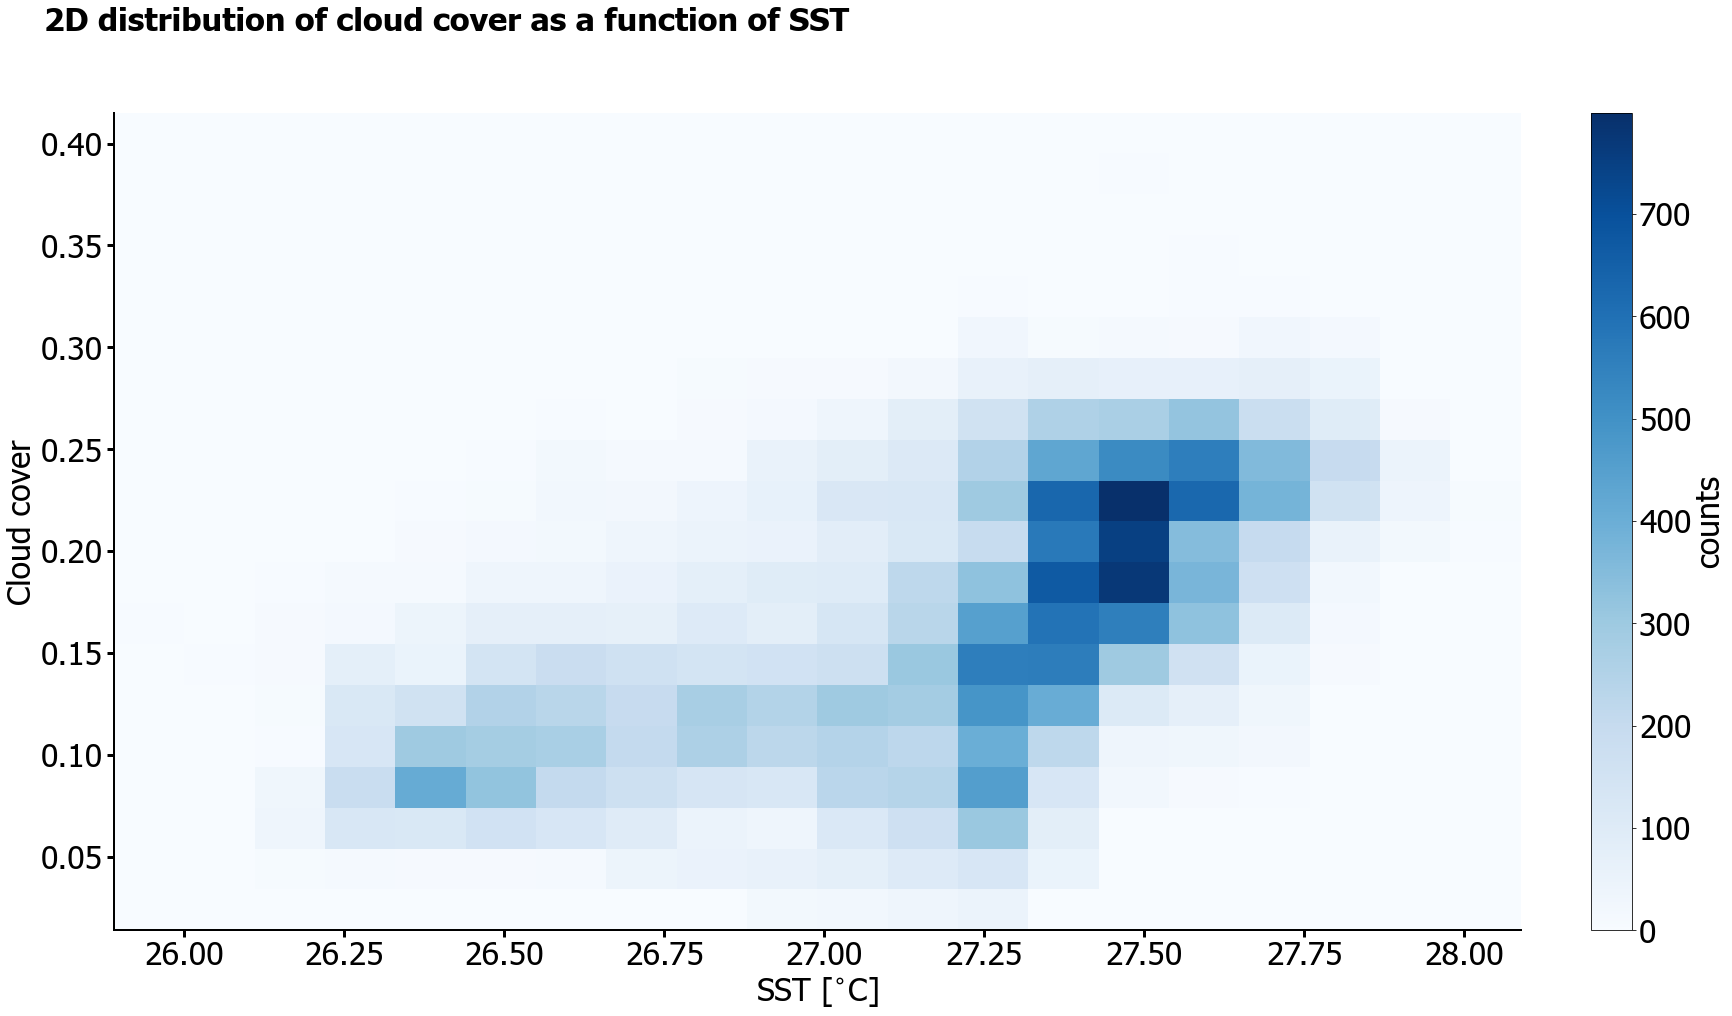

In [35]:
fig, ax = plt.subplots(figsize=(24,14), constrained_layout=True)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines["bottom"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.tick_params(which='minor', length=7, width=3)
ax.tick_params(which='major', length=7, width=3)
ax.text(-0.05, 1.1, '2D distribution of cloud cover as a function of SST',  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)

plt.hist2d(SST.data.flatten(order='C'), cc.flatten(order='C'),
           range=[[SST.min().data,SST.max().data],[cc.min(), cc.max()]],
           bins = 20, cmap='Blues')
plt.colorbar(label='counts')
plt.ylabel('Cloud cover')
plt.xlabel('SST [$^{\circ}$C]')
#save the figure
plt.savefig(path_out_plots + 'figure_GOES_CC.png',bbox_inches='tight',dpi=300)

In [ ]:

plt.rcParams['font.size'] = '16'
fig, ax = plt.subplots(figsize=(14,8), dpi=300)
plt.hist2d(cc.flatten(order='C'),SST.data.flatten(order='C'),
           range=[[cc.min(), cc.max()], [SST.min().data,SST.max().data]],
           bins = 20, cmap='viridis')
plt.title(date + ' 2D histogram GOES cloud cover vs SST MUR', loc='left')
plt.colorbar(label='counts')
plt.xlabel('Cloud Cover')
plt.ylabel('SST [°C]')
#save the figure
plt.savefig(save_path + date + '_ACM'  + '_LT'+'.png',
                bbox_inches='tight',dpi=300)